# UrbanSound machine learning

* The codes : learned from

- youtube video series "Deep Learning (for audio) using Python" -- using librosa
    https://www.youtube.com/watch?v=m3XbqfIij_Y  and more
    
- towarddatasience -- urbansound
   Part1: https://towardsdatascience.com/urban-sound-classification-part-1-99137c6335f9
   PArt2: https://towardsdatascience.com/urban-sound-classification-part-2-sample-rate-conversion-librosa-ba7bc88f209a
    

In [12]:
# marsys -- music genres, folders-- many files.

import pandas as pd
import os
import librosa
import math
import json
import numpy as np

DATASET_PATH = "urbansound_reduced"  # in the video, the files are music files
JASON_PATH = "data.json"

In [2]:
metadata = pd.read_csv(f"{DATASET_PATH}/metadata/UrbanSound8K.csv")

In [3]:
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
filename = "7383-3-0-0.wav"
metadata.loc[metadata["slice_file_name"]==filename]

,slice_file_name,fsID,start,end,salience,fold,classID,class
7660,7383-3-0-0.wav,7383,3.9021,7.9021,1,1,3,dog_bark


In [21]:
metadata.loc[metadata["fold"]==1].head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
64,101415-3-0-2.wav,101415,1.000000,5.000000,1,1,3,dog_bark
65,101415-3-0-3.wav,101415,1.500000,5.500000,1,1,3,dog_bark
66,101415-3-0-8.wav,101415,4.000000,8.000000,1,1,3,dog_bark
105,102106-3-0-0.wav,102106,2.243852,3.884477,2,1,3,dog_bark
106,102305-6-0-0.wav,102305,0.000000,2.611610,1,1,6,gun_shot


In [4]:
metadata.loc[metadata["fold"]==1].nunique()

slice_file_name    873
fsID               134
start              488
end                506
salience             2
fold                 1
classID             10
class               10
dtype: int64

Converted Sample Rate :  22050
Converted Signal min ~ max :  -0.32452014 ~ 0.29852936


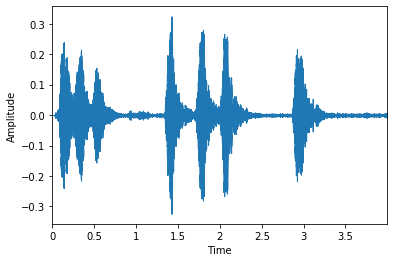

In [13]:
import librosa.display
import matplotlib.pyplot as plt

#waveform,   sr * T => 22050 * 30,  sr=sampling rate
filepath = f"{DATASET_PATH}/audio/fold1/{filename}"
signal, sr = librosa.load(filepath, sr=22050)

print("Converted Sample Rate : ", sr)
print("Converted Signal min ~ max : ", np.min(signal), "~", np.max(signal))

librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

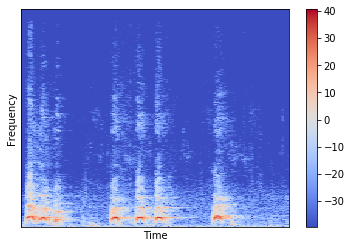

In [18]:
# short time Fourier Transform (stft) --- spectrogram
n_fft = 2048 # number of samples
hop_length = 512 # amount shifting F.T. to right , sliding to right
stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)


log_spectrogram = librosa.amplitude_to_db(spectrogram)


librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [16]:

# test

SAMPLE_RATE = 22050
DURATION = 4 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def save_urban_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    
    data = {
        "class" : [],
        "mfcc" : [],
        "classID" : []
    }
    
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment =  math.ceil(num_samples_per_segment / hop_length) # ex) 1.2 => 2
    
    print("expected number of mfcc vectors per segment:", expected_num_mfcc_vectors_per_segment)
    
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensure we are not at the root level
        if dirpath is not dataset_path:
            for fn in filenames:
        
                if fn == ".DS_Store":
                    continue
                excerpt = metadata.loc[metadata["slice_file_name"]==fn]
                filepath = os.path.join(dirpath,fn)
                print(filepath)
                signal, sr = librosa.load(filepath, sr=SAMPLE_RATE)
                
                for s in range(num_segments):
                    start_sample = num_samples_per_segment * s
                    finish_sample = start_sample + num_samples_per_segment
                    
                    #print("start sample", start_sample)
                    #print("finish sampel", finish_sample)
                    if len(signal) < finish_sample:
                        #print("short signal")
                        #print(filepath)
                        break
                        
                    mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                sr=sr,
                                                n_mfcc=13,
                                                n_fft=n_fft,
                                                hop_length=hop_length)

                    mfcc = mfcc.T # transpose
                    print(np.shape(mfcc))
                    if len(mfcc) ==  expected_num_mfcc_vectors_per_segment:
                        data["class"].append(excerpt["class"].values.tolist())
                        data["mfcc"].append(mfcc.tolist())
                        data["classID"].append(excerpt["classID"].values.tolist())
    
   # with open(json_path, "w") as fp:
    #    json.dump(data, fp, indent=4)


In [17]:
save_urban_mfcc(DATASET_PATH+"/audio", JASON_PATH, num_segments=4)

expected number of mfcc vectors per segment: 44
urbansound_reduced/audio/fold2/4911-3-0-0.wav
urbansound_reduced/audio/fold2/4201-3-1-0.wav
urbansound_reduced/audio/fold2/4201-3-3-0.wav
(44, 13)
urbansound_reduced/audio/fold2/4201-3-2-0.wav
urbansound_reduced/audio/fold2/4201-3-0-0.wav
urbansound_reduced/audio/fold1/7061-6-0-0.wav
(44, 13)
(44, 13)
urbansound_reduced/audio/fold1/9031-3-1-0.wav
urbansound_reduced/audio/fold1/7383-3-0-0.wav
(44, 13)
(44, 13)
(44, 13)
(44, 13)
urbansound_reduced/audio/fold1/7383-3-0-1.wav
(44, 13)
(44, 13)
(44, 13)
(44, 13)
urbansound_reduced/audio/fold1/7383-3-1-0.wav
(44, 13)
(44, 13)
(44, 13)
(44, 13)


  mfcc0 double precision,
  mfcc1 double precision,
  mfcc2 double precision,
  mfcc3 double precision,
  mfcc4 double precision,
  mfcc5 double precision,
  mfcc6 double precision,
  mfcc7 double precision,
  mfcc8 double precision,
  mfcc9 double precision,
  mfcc10 double precision,
  mfcc11 double precision,
  mfcc12 double precision,
  mfcc13 double precision,
  mfcc14 double precision,
  mfcc15 double precision,
  mfcc16 double precision,
  mfcc17 double precision,
  mfcc18 double precision,
  mfcc19 double precision,
  mfcc20 double precision,
  mfcc21 double precision,
  mfcc22 double precision,
  mfcc23 double precision,
  mfcc24 double precision,
  mfcc25 double precision,
  mfcc26 double precision,
  mfcc27 double precision,
  mfcc28 double precision,
  mfcc29 double precision,
  mfcc30 double precision,
  mfcc31 double precision,
  mfcc32 double precision,
  mfcc33 double precision,
  mfcc34 double precision,
  mfcc35 double precision,
  mfcc36 double precision,
  mfcc37 do